# Depedency Analysis

By collecting data on the projects within the WETO portfolio that use other tools
within the portfolio, we can get a sense for the software projects that are at the "core"
of the capabilities.

This network is divided into two types of connectivity:
1. **Direct connections** are software that are connected within the code, so they may
    communicate directly through API's, share memory, and be distributed as a bundle.
2. **Indirect connections** are software that require the outputs of other tools in order
    to construct their inputs. These are connected through workflows rather than code.

In [1]:
from pathlib import Path
import yaml
import networkx as nx

models = [
    "anba4",
    "floris",
    "openfast",
    "openoa",
    "rosco",
    "sonata",
    "weis",
    "windse",
    "wisdem",
    "wombat",
]
model_connectivity = {}
for model in models:
    attributes = yaml.safe_load( open(Path("..", "..", "software_attributes", "database", f"{model}.yaml"), "r") )
    # print(model)
    if "dependencies" not in attributes:
        continue
    model_connectivity[model] = attributes["dependencies"]

network_graph = nx.DiGraph()
for model, connections in model_connectivity.items():
    for c in connections:
        weight = 1 if c[1] == "direct" else 2
        network_graph.add_edge(model, c[0], weight=weight)

/var/folders/yp/vdv3q8mn4xj1_m277lk54s75tvdqcf/T/ipykernel_23660/1330741652.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  layout = nx.nx_pydot.graphviz_layout(network_graph, prog="dot")


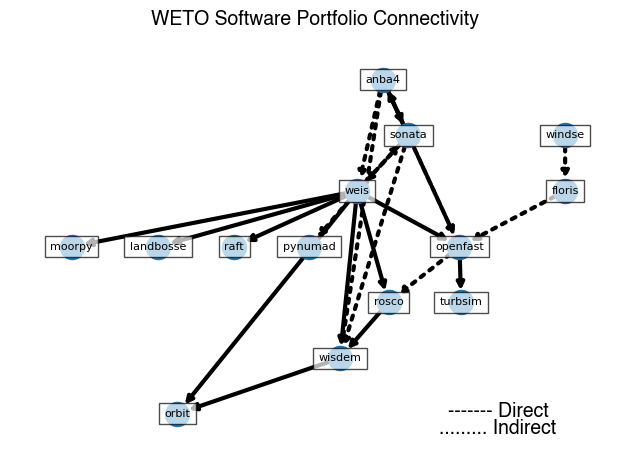

In [2]:
import matplotlib.pyplot as plt

edges_direct = [(u, v) for (u, v, d) in network_graph.edges(data=True) if d["weight"] == 1]
edges_indirect = [(u, v) for (u, v, d) in network_graph.edges(data=True) if d["weight"] == 2]

layout = nx.nx_pydot.graphviz_layout(network_graph, prog="dot")

# nodes
nx.draw_networkx_nodes(
    network_graph,
    layout,
    # node_size=1000
)

# edges
nx.draw_networkx_edges(
    network_graph,
    layout,
    edgelist=edges_direct,
    width=3
)
nx.draw_networkx_edges(
    network_graph,
    layout,
    edgelist=edges_indirect,
    width=3,
    # alpha=0.5,
    # edge_color="b",
    style=":"
)

# node labels
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(
    network_graph,
    layout,
    font_size=8,
    bbox=label_options,
    # font_family="sans-serif"
)
# edge weight labels
# edge_labels = nx.get_edge_attributes(network_graph, "weight")
# nx.draw_networkx_edge_labels(network_graph, pos, edge_labels)

# Title/legend
ax = plt.gca()
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("WETO Software Portfolio Connectivity", font)

# Change font color for legend
font["color"] = "k"
ax.text(
    0.80,
    0.10,
    "------- Direct",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    # "------- Direct",
    "......... Indirect",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()